In [1]:
import numpy as np
import math
import tensorflow as tf
sess = tf.InteractiveSession()

In [2]:
ratio_exp_base = 2
ratio_max_exp = 2
ratio_min_exp = -ratio_max_exp
ratio_support = tf.constant([ratio_exp_base**exp for exp in 
                             range(ratio_min_exp,ratio_max_exp+1)])
ratio_num_atoms = tf.shape(ratio_support)[0]
ratio_cmin = ratio_support[0]
ratio_cmax = ratio_support[-1]

In [3]:
ratio_support.eval()

array([0.25, 0.5 , 1.  , 2.  , 4.  ], dtype=float32)

In [4]:
supports = tf.constant([[ 2.25,  4.5 ,  9.  , 18.  , 36.  ],
                        [0.025, 0.05 , 0.1  , 0.2  , 0.4  ]])
weights = tf.constant([[0.1, 0.6, 0.1, 0.1, 0.1],
                       [0.1, 0.2, 0.5, 0.1, 0.1]])
target_support = ratio_support

In [5]:
supports.eval()

array([[2.25e+00, 4.50e+00, 9.00e+00, 1.80e+01, 3.60e+01],
       [2.50e-02, 5.00e-02, 1.00e-01, 2.00e-01, 4.00e-01]], dtype=float32)

In [6]:
target_support_deltas_forward = tf.pad(target_support[1:] - target_support[:-1], 
                                       tf.constant([[0,1]]), constant_values=1)
target_support_deltas_backward = tf.pad(target_support[:-1] - target_support[1:],
                                        tf.constant([[1,0]]), constant_values=-1)

In [7]:
target_support_deltas_backward.eval()

array([-1.  , -0.25, -0.5 , -1.  , -2.  ], dtype=float32)

In [8]:
tf.pad(target_support_deltas_forward, tf.constant([[0,1]]), constant_values=1).eval()

array([0.25, 0.5 , 1.  , 2.  , 1.  , 1.  ], dtype=float32)

In [9]:
batch_size = tf.shape(supports)[0]
num_dims = tf.shape(target_support)[0]
v_min, v_max = target_support[0], target_support[-1]

In [10]:
clipped_support = tf.clip_by_value(supports, v_min, v_max)[:, None, :]

In [11]:
tiled_support = tf.tile([clipped_support], [1, 1, num_dims, 1])

In [12]:
tiled_support

<tf.Tensor 'Tile:0' shape=(1, 2, 5, 5) dtype=float32>

In [13]:
reshaped_target_support = tf.tile(target_support[:, None], [batch_size, 1])
reshaped_target_support = tf.reshape(reshaped_target_support, 
                                     [batch_size, num_dims, 1])

In [14]:
reshaped_target_support

<tf.Tensor 'Reshape:0' shape=(2, 5, 1) dtype=float32>

In [15]:
reshaped_target_support_deltas_forward = tf.tile(target_support_deltas_forward[:, None], 
                                                 [batch_size, num_dims])
reshaped_target_support_deltas_forward = tf.reshape(reshaped_target_support_deltas_forward,
                                                    [batch_size, num_dims, num_dims])

In [16]:
reshaped_target_support_deltas_forward.eval()

array([[[0.25, 0.25, 0.25, 0.25, 0.25],
        [0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
        [1.  , 1.  , 1.  , 1.  , 1.  ],
        [2.  , 2.  , 2.  , 2.  , 2.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  ]],

       [[0.25, 0.25, 0.25, 0.25, 0.25],
        [0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
        [1.  , 1.  , 1.  , 1.  , 1.  ],
        [2.  , 2.  , 2.  , 2.  , 2.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  ]]], dtype=float32)

In [17]:
reshaped_target_support_deltas_backward = tf.tile(target_support_deltas_backward[:, None], 
                                                 [batch_size, num_dims])
reshaped_target_support_deltas_backward = tf.reshape(reshaped_target_support_deltas_backward,
                                                    [batch_size, num_dims, num_dims])

In [18]:
reshaped_target_support_deltas_backward

<tf.Tensor 'Reshape_2:0' shape=(2, 5, 5) dtype=float32>

In [19]:
numerator = tiled_support - reshaped_target_support
numerator_sign_mask = numerator < 0

In [20]:
numerator.eval()

array([[[[ 2.        ,  3.75      ,  3.75      ,  3.75      ,
           3.75      ],
         [ 1.75      ,  3.5       ,  3.5       ,  3.5       ,
           3.5       ],
         [ 1.25      ,  3.        ,  3.        ,  3.        ,
           3.        ],
         [ 0.25      ,  2.        ,  2.        ,  2.        ,
           2.        ],
         [-1.75      ,  0.        ,  0.        ,  0.        ,
           0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.15      ],
         [-0.25      , -0.25      , -0.25      , -0.25      ,
          -0.09999999],
         [-0.75      , -0.75      , -0.75      , -0.75      ,
          -0.6       ],
         [-1.75      , -1.75      , -1.75      , -1.75      ,
          -1.6       ],
         [-3.75      , -3.75      , -3.75      , -3.75      ,
          -3.6       ]]]], dtype=float32)

In [21]:
reshaped_target_support_deltas = tf.where(numerator_sign_mask[0], 
                                          reshaped_target_support_deltas_backward,
                                          reshaped_target_support_deltas_forward)

In [22]:
reshaped_target_support_deltas.eval()

array([[[ 0.25,  0.25,  0.25,  0.25,  0.25],
        [ 0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ],
        [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 2.  ,  2.  ,  2.  ,  2.  ,  2.  ],
        [-2.  ,  1.  ,  1.  ,  1.  ,  1.  ]],

       [[ 0.25,  0.25,  0.25,  0.25,  0.25],
        [-0.25, -0.25, -0.25, -0.25, -0.25],
        [-0.5 , -0.5 , -0.5 , -0.5 , -0.5 ],
        [-1.  , -1.  , -1.  , -1.  , -1.  ],
        [-2.  , -2.  , -2.  , -2.  , -2.  ]]], dtype=float32)

In [23]:
quotient = 1 - numerator / reshaped_target_support_deltas

In [24]:
quotient.eval()

array([[[[ -7.        , -14.        , -14.        , -14.        ,
          -14.        ],
         [ -2.5       ,  -6.        ,  -6.        ,  -6.        ,
           -6.        ],
         [ -0.25      ,  -2.        ,  -2.        ,  -2.        ,
           -2.        ],
         [  0.875     ,   0.        ,   0.        ,   0.        ,
            0.        ],
         [  0.125     ,   1.        ,   1.        ,   1.        ,
            1.        ]],

        [[  1.        ,   1.        ,   1.        ,   1.        ,
            0.39999998],
         [  0.        ,   0.        ,   0.        ,   0.        ,
            0.6       ],
         [ -0.5       ,  -0.5       ,  -0.5       ,  -0.5       ,
           -0.20000005],
         [ -0.75      ,  -0.75      ,  -0.75      ,  -0.75      ,
           -0.6       ],
         [ -0.875     ,  -0.875     ,  -0.875     ,  -0.875     ,
           -0.79999995]]]], dtype=float32)

In [25]:
clipped_quotient = tf.clip_by_value(quotient, 0, 1)

In [26]:
clipped_quotient.eval()

array([[[[0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.875     , 0.        , 0.        , 0.        , 0.        ],
         [0.125     , 1.        , 1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        , 1.        , 0.39999998],
         [0.        , 0.        , 0.        , 0.        , 0.6       ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]]]],
      dtype=float32)

In [27]:
weights = weights[:, None, :]

inner_prod = clipped_quotient * weights

projection = tf.reduce_sum(inner_prod, 3)
projection = tf.reshape(projection, [batch_size, num_dims])

In [28]:
projection.eval()

array([[0.        , 0.        , 0.        , 0.0875    , 0.9125001 ],
       [0.94000006, 0.06      , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [145]:
import matplotlib
#from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib notebook

def plot_c_value_distribution(c_value, support, dist_values, width): 
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_title('c: ' + str(c_value))
    ax.set_xlabel('c value')
    ax.set_ylabel('probability')
    ax.bar(support, dist_values, width=width, alpha=0.5, align='edge', linewidth=1, edgecolor='black')
    fig.canvas.draw()
    # Now we can save it to a numpy array.
    #dist = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    #dist = dist.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    #plt.close('all')
    #return dist

<IPython.core.display.Javascript object>


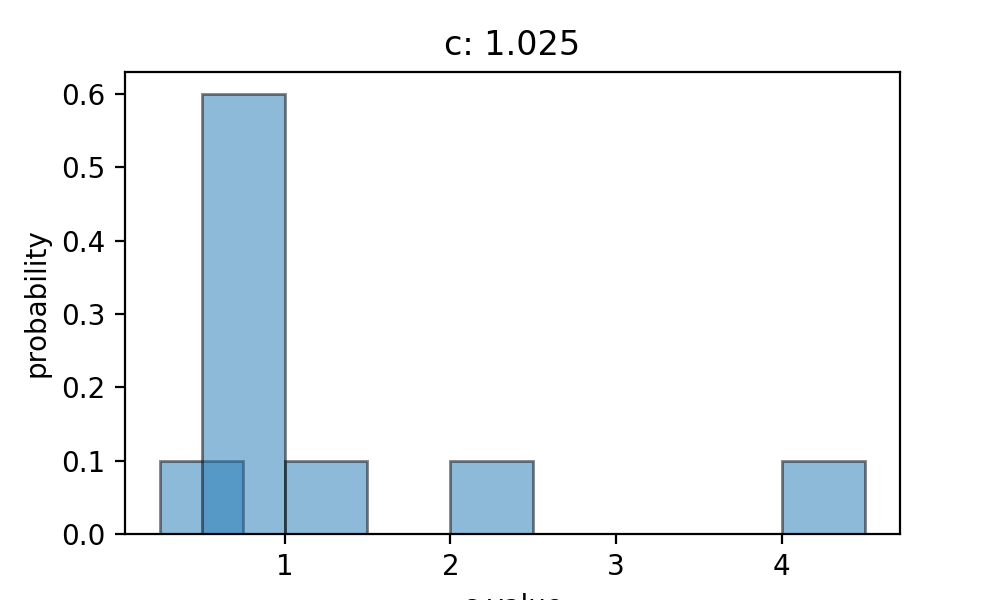

In [146]:
import numpy as np

support = target_support
dist_values = tf.constant([0.1, 0.6, 0.1, 0.1, 0.1])
c_value = tf.reduce_sum(support*dist_values, axis=0)
width = 0.5
plot_c_value_distribution(c_value.eval(), support.eval(), dist_values.eval(), width)

In [139]:
dist_values

<tf.Tensor 'strided_slice_73:0' shape=(1, 5) dtype=float32>

In [9]:
def project_distribution(supports, weights, target_support):
    target_support_deltas = target_support[1:] - target_support[:-1]
    delta_z = target_support_deltas[0]
    
    supports.shape.assert_is_compatible_with(weights.shape)
    supports[0].shape.assert_is_compatible_with(target_support.shape)
    target_support.shape.assert_has_rank(1)

    v_min, v_max = target_support[0], target_support[-1]
    batch_size = tf.shape(supports)[0]
    num_dims = tf.shape(target_support)[0]
    clipped_support = tf.clip_by_value(supports, v_min, v_max)[:, None, :]
    tiled_support = tf.tile([clipped_support], [1, 1, num_dims, 1])
    reshaped_target_support = tf.tile(target_support[:, None], [batch_size, 1])
    reshaped_target_support = tf.reshape(reshaped_target_support,
                                         [batch_size, num_dims, 1])
    numerator = tf.abs(tiled_support - reshaped_target_support)
    quotient = 1 - (numerator / delta_z)
    clipped_quotient = tf.clip_by_value(quotient, 0, 1)
    weights = weights[:, None, :]
    inner_prod = clipped_quotient * weights
    projection = tf.reduce_sum(inner_prod, 3)
    projection = tf.reshape(projection, [batch_size, num_dims])
    return projection

In [10]:
def project_distribution_general(supports, weights, target_support):
    target_support_deltas_forward = tf.pad(target_support[1:] - target_support[:-1], 
                                         tf.constant([[0,1]]), constant_values=1)
    target_support_deltas_backward = tf.pad(target_support[:-1] - target_support[1:],
                                          tf.constant([[1,0]]), constant_values=-1)
    
    supports.shape.assert_is_compatible_with(weights.shape)
    supports[0].shape.assert_is_compatible_with(target_support.shape)
    target_support.shape.assert_has_rank(1)

    v_min, v_max = target_support[0], target_support[-1]
    batch_size = tf.shape(supports)[0]
    num_dims = tf.shape(target_support)[0]

    clipped_support = tf.clip_by_value(supports, v_min, v_max)[:, None, :]
    tiled_support = tf.tile([clipped_support], [1, 1, num_dims, 1])

    reshaped_target_support = tf.tile(target_support[:, None], [batch_size, 1])
    reshaped_target_support = tf.reshape(reshaped_target_support,
                                      [batch_size, num_dims, 1])

    reshaped_target_support_deltas_forward = tf.tile(target_support_deltas_forward[:, None], 
                                                    [batch_size, num_dims])
    reshaped_target_support_deltas_forward = tf.reshape(reshaped_target_support_deltas_forward,
                                                      [batch_size, num_dims, num_dims])

    reshaped_target_support_deltas_backward = tf.tile(target_support_deltas_backward[:, None], 
                                                    [batch_size, num_dims])
    reshaped_target_support_deltas_backward = tf.reshape(reshaped_target_support_deltas_backward,
                                                        [batch_size, num_dims, num_dims])

    numerator = tiled_support - reshaped_target_support
    numerator_sign_mask = numerator[0] <= 0

    reshaped_target_support_deltas = tf.where(numerator_sign_mask, 
                                            reshaped_target_support_deltas_backward,
                                            reshaped_target_support_deltas_forward)

    quotient = 1 - (numerator / reshaped_target_support_deltas)
    clipped_quotient = tf.clip_by_value(quotient, 0, 1)

    weights = weights[:, None, :]
    inner_prod = clipped_quotient * weights

    projection = tf.reduce_sum(inner_prod, 3)
    projection = tf.reshape(projection, [batch_size, num_dims])
    return projection

In [44]:
ratio_cmin = 0.01
ratio_cmax = 10
ratio_num_atoms = 51
ratio_discount_factor = 16.3
constant_term = -1.5

In [45]:
fixed_support = tf.linspace(float(ratio_cmin), float(ratio_cmax), ratio_num_atoms)
probs = tf.reshape(tf.constant([math.cos(x)**2 for x in np.linspace(0,3.14,ratio_num_atoms)]), [1,-1])
new_support = tf.reshape(tf.add(ratio_discount_factor * fixed_support, constant_term), [1,-1])

In [46]:
probs.shape

TensorShape([Dimension(1), Dimension(51)])

In [47]:
projection1 = project_distribution(new_support, probs, fixed_support)
projection2 = project_distribution_general(new_support, probs, fixed_support)

In [48]:
tf.reduce_sum((projection2-projection1)).eval()

-4.8094375e-05

In [49]:
tf.reduce_sum(probs).eval()

25.987335

In [51]:
tf.reduce_sum(projection2).eval()

25.987335